In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.signal import find_peaks

# 把切點從串列轉成整數

In [3]:

# 將字串格式的 cut_point 轉為 list[int]
def parse_cut_point_string(s):
    if isinstance(s, str):
        s = s.strip().replace('[', '').replace(']', '')  # 去除中括號
        return list(map(int, s.split()))  # 空白分隔後轉為整數
    return []


# 找波谷

In [2]:
from scipy.signal import find_peaks
import numpy as np

def detect_valleys(signal, 
                   initial_distance=85, initial_prom=8000, min_peaks=28,
                   min_distance=20, min_prom=1000, step_prom=100):
    
    # 初次抓取
    cutpoints_1 = list(find_peaks(-signal, distance=initial_distance, prominence=initial_prom)[0])
    cutpoints_2 = set(cutpoints_1)

    if len(cutpoints_1) == min_peaks:
        return sorted(cutpoints_1), "sufficient"

    # 雙層迴圈掃描更多點
    current_distance = initial_distance
    while current_distance >= min_distance:
        current_prom = initial_prom
        
        while current_prom >= min_prom:
            new_peaks = find_peaks(-signal, distance=current_distance, prominence=current_prom)[0]
            for p in new_peaks:
                if all(abs(p - existing) >= min_distance for existing in cutpoints_2):
                    cutpoints_2.add(p)
            current_prom -= step_prom
        current_distance -= 1

    # ✅ 最後再檢查總數是否超過 min_peaks，若超過只保留 signal 最小（最深）的前 27 個
    if len(cutpoints_2) > min_peaks:
        sorted_by_depth = sorted(cutpoints_2, key=lambda p: signal[p])
        return sorted(sorted_by_depth[:min_peaks]), "limited_to_28_by_depth"

    return sorted(cutpoints_2), "max_iter_reached"



# 畫圖看效果

C:\Users\USER\AppData\Local\Temp\ipykernel_19204\260600806.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(txt_path, delim_whitespace=True, skiprows=1, header=None)


波谷出現次數：28


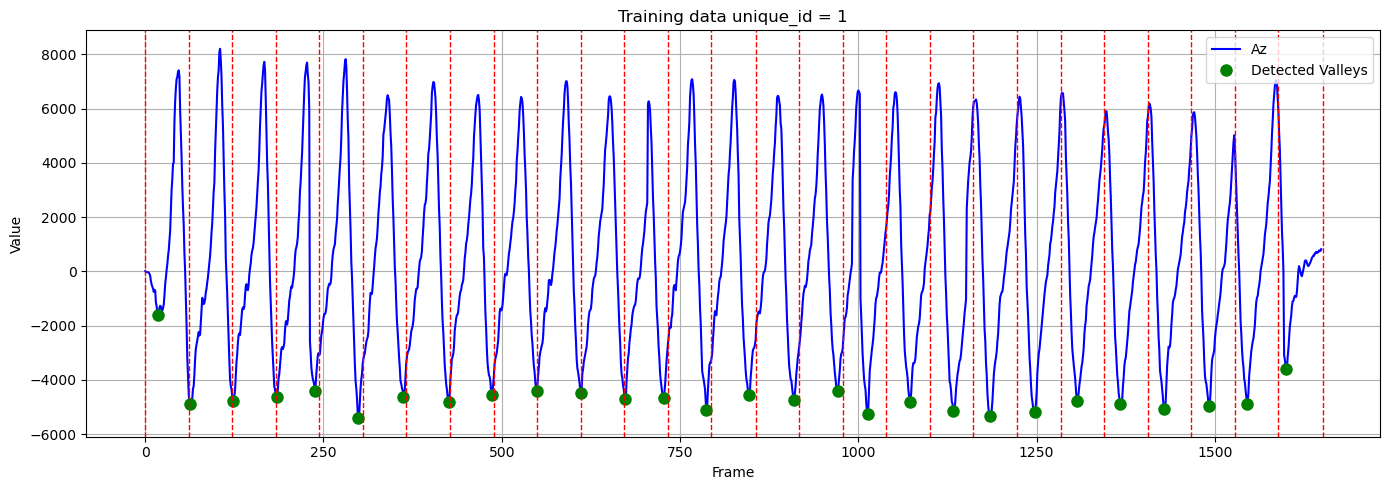

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import ast
id = 1

# # === 1. 設定資料路徑 ===
txt_path = rf"39_Training_Dataset\train_data\{id}.txt" 
csv_path = r"39_Training_Dataset\train_info.csv"  

# txt_path = rf"C:\Users\USER\Desktop\桌球競賽\39_Test_Dataset\test_data\{id}.txt" #1983/3030
# csv_path = rf"C:\Users\USER\Desktop\桌球競賽\39_Test_Dataset\test_info.csv"

# === 2. 讀取測試 txt ===
df = pd.read_csv(txt_path, delim_whitespace=True, skiprows=1, header=None)
df.columns = [f'col_{i+1}' for i in range(df.shape[1])]
signal = df['col_3'].values

# === 3. 自動抓波谷 ===


# 假設 signal 是 numpy array
#valleys, status = find_peaks(-signal, distance = 20,prominence=5000)

valleys, status = detect_valleys(signal)
print(f"波谷出現次數：{len(valleys)}")

# === 4. 讀取 cut_point 並轉成 list[int] ===
df_info = pd.read_csv(csv_path)
cut_point_str = df_info[df_info['unique_id'] == id]['cut_point'].values[0]  # 確保 unique_id 有 match

def parse_cut_point_string(s):
    return list(map(int, s.strip().strip('[]').split()))

cut_points = parse_cut_point_string(cut_point_str)

# === 5. 畫圖 ===
plt.figure(figsize=(14, 5))
plt.plot(signal, label='Az', color='blue')
plt.plot(valleys, signal[valleys], 'go', label='Detected Valleys', markersize=8)

# 加上 cut_point（紅色虛線）
for cp in cut_points:
    plt.axvline(x=cp, color='red', linestyle='--', linewidth=1)

plt.title(f"Training data unique_id = {id}")
plt.xlabel("Frame")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 訓練集跟測試及更新切點並轉存csv檔案

In [ ]:
import os
import pandas as pd

# === 路徑設定 ===
csv_path = r"39_Training_Dataset\train_info.csv"
txt_folder = r"39_Training_Dataset\train_data"
output_folder = "new_cut_train_1"
os.makedirs(output_folder, exist_ok=True)

# === 處理每個 mode ===
for mode in range(1, 11):
    df_info = pd.read_csv(csv_path)
    df_info = df_info[df_info['mode'] == mode].copy()

    if df_info.empty:
        continue

    new_cutpoints_dict = {}

    for _, row in df_info.iterrows():
        unique_id = row['unique_id']
        txt_path = os.path.join(txt_folder, f"{unique_id}.txt")

        try:
            df = pd.read_csv(txt_path, sep=r'\s+', skiprows=1, header=None)
            df.columns = [f'col_{i+1}' for i in range(df.shape[1])]
            signal = df['col_3'].values

            # 偵測波谷
            valleys, _ = detect_valleys(signal)

            # 儲存為字串格式
            cutpoints_str = "[ " + " ".join(map(str, valleys)) + " ]"
            new_cutpoints_dict[unique_id] = cutpoints_str

        except Exception as e:
            print(f"❌ unique_id={unique_id} 發生錯誤：{e}")

    # === 套用回 df_info 並儲存 CSV ===
    df_info['cut_point'] = df_info['unique_id'].apply(
        lambda uid: new_cutpoints_dict.get(uid, '')
    )

    output_path = os.path.join(output_folder, f"train_info_mode{mode}_updated.csv")
    df_info.to_csv(output_path, index=False, encoding="utf-8")
    print(f"✅ 已儲存: {output_path}")


✅ 已儲存: new_cut_train_1\train_info_mode1_updated.csv
✅ 已儲存: new_cut_train_1\train_info_mode2_updated.csv
✅ 已儲存: new_cut_train_1\train_info_mode3_updated.csv
✅ 已儲存: new_cut_train_1\train_info_mode4_updated.csv
✅ 已儲存: new_cut_train_1\train_info_mode5_updated.csv
✅ 已儲存: new_cut_train_1\train_info_mode6_updated.csv
✅ 已儲存: new_cut_train_1\train_info_mode7_updated.csv
✅ 已儲存: new_cut_train_1\train_info_mode8_updated.csv
✅ 已儲存: new_cut_train_1\train_info_mode9_updated.csv
✅ 已儲存: new_cut_train_1\train_info_mode10_updated.csv


In [ ]:
import os
import pandas as pd

# === 路徑設定 ===
csv_path = r"39_Test_Dataset\test_info.csv"
txt_folder = r"39_Test_Dataset\test_data"
output_folder = "new_cut_test_1"
os.makedirs(output_folder, exist_ok=True)

# === 處理每個 mode ===
for mode in range(1, 11):
    df_info = pd.read_csv(csv_path)
    df_info = df_info[df_info['mode'] == mode].copy()

    if df_info.empty:
        continue

    new_cutpoints_dict = {}

    for _, row in df_info.iterrows():
        unique_id = row['unique_id']
        txt_path = os.path.join(txt_folder, f"{unique_id}.txt")

        try:
            df = pd.read_csv(txt_path, sep=r'\s+', skiprows=1, header=None)
            df.columns = [f'col_{i+1}' for i in range(df.shape[1])]
            signal = df['col_3'].values

            # 偵測波谷
            valleys, _ = detect_valleys(signal)

            # 儲存為字串格式
            cutpoints_str = "[ " + " ".join(map(str, valleys)) + " ]"
            new_cutpoints_dict[unique_id] = cutpoints_str

        except Exception as e:
            print(f"❌ unique_id={unique_id} 發生錯誤：{e}")

    # === 套用回 df_info 並儲存 CSV ===
    df_info['cut_point'] = df_info['unique_id'].apply(
        lambda uid: new_cutpoints_dict.get(uid, '')
    )

    output_path = os.path.join(output_folder, f"test_info_mode{mode}_updated.csv")
    df_info.to_csv(output_path, index=False, encoding="utf-8")
    print(f"✅ 已儲存: {output_path}")


✅ 已儲存: new_cut_test_1\test_info_mode1_updated.csv
✅ 已儲存: new_cut_test_1\test_info_mode2_updated.csv
✅ 已儲存: new_cut_test_1\test_info_mode3_updated.csv
✅ 已儲存: new_cut_test_1\test_info_mode4_updated.csv
✅ 已儲存: new_cut_test_1\test_info_mode5_updated.csv
✅ 已儲存: new_cut_test_1\test_info_mode6_updated.csv
✅ 已儲存: new_cut_test_1\test_info_mode7_updated.csv
✅ 已儲存: new_cut_test_1\test_info_mode8_updated.csv
✅ 已儲存: new_cut_test_1\test_info_mode9_updated.csv
✅ 已儲存: new_cut_test_1\test_info_mode10_updated.csv
